In [1]:
import pandas as pd

# Read in the files
train_df = pd.read_csv('../data/cleaned-data/train.txt', delimiter='\t', header=None, encoding='utf-8')
valid_df = pd.read_csv('../data/cleaned-data/valid.txt', delimiter='\t', header=None, encoding='utf-8')
test_df = pd.read_csv('../data/cleaned-data/test.txt', delimiter='\t', header=None, encoding='utf-8')

# Define the columns header
columns = ['CATEGORY', 'TITLE']

# Assign the headers to the dataframe
train_df.columns = columns
valid_df.columns = columns
test_df.columns = columns

In [2]:
# Calculate the number of samples for each category in each set
train_label_counts = train_df['CATEGORY'].value_counts()
valid_label_counts = valid_df['CATEGORY'].value_counts()
test_label_counts = test_df['CATEGORY'].value_counts()

print("Number of samples for each category in train set:", train_label_counts, sep="\n", end="\n\n")
print("Number of samples for each category in validation set:", valid_label_counts, sep="\n", end="\n\n")
print("Number of samples for each category in test set:", test_label_counts, sep="\n")

Number of samples for each category in train set:
CATEGORY
b    4500
e    4223
t    1229
m     732
Name: count, dtype: int64

Number of samples for each category in validation set:
CATEGORY
b    556
e    543
t    153
m     84
Name: count, dtype: int64

Number of samples for each category in test set:
CATEGORY
b    571
e    528
t    143
m     94
Name: count, dtype: int64


In [3]:
# Calculate the average number of words, maximum number of words, and minimum number of words in the samples in the train, valid, and test sets
def calculate_word_stats(df):
    """
    Calculate the average, maximum, and minimum number of words in the titles of samples in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing the samples.

    Returns:
    tuple: A tuple containing the average, maximum, and minimum number of words.

    Note:
    This function used for title stored in the 'TITLE' column of the DataFrame.
    """
    # Split each title into words and count the number of words
    word_counts = df['TITLE'].str.split().apply(len)
    # Calculate the average number of words
    avg_word_count = word_counts.mean()
    # Find the maximum number of words
    max_word_count = word_counts.max()
    # Find the minimum number of words
    min_word_count = word_counts.min()
    return avg_word_count, max_word_count, min_word_count

# Calculate word statistics for the train, valid, and test sets
train_avg_word_count, train_max_word_count, train_min_word_count = calculate_word_stats(train_df)
valid_avg_word_count, valid_max_word_count, valid_min_word_count = calculate_word_stats(valid_df)
test_avg_word_count, test_max_word_count, test_min_word_count = calculate_word_stats(test_df)

# Print the word statistics for the train set
print("\nTrain set:")
print("Average number of words in samples:", train_avg_word_count)
print("Maximum number of words in samples:", train_max_word_count)
print("Minimum number of words in samples:", train_min_word_count)

# Print the word statistics for the validation set
print("\nValidation set:")
print("Average number of words in samples:", valid_avg_word_count)
print("Maximum number of words in samples:", valid_max_word_count)
print("Minimum number of words in samples:", valid_min_word_count)

# Print the word statistics for the test set
print("\nTest set:")
print("Average number of words in samples:", test_avg_word_count)
print("Maximum number of words in samples:", test_max_word_count)
print("Minimum number of words in samples:", test_min_word_count)


Train set:
Average number of words in samples: 10.766286035192811
Maximum number of words in samples: 19
Minimum number of words in samples: 2

Validation set:
Average number of words in samples: 10.848802395209582
Maximum number of words in samples: 18
Minimum number of words in samples: 2

Test set:
Average number of words in samples: 10.764221556886227
Maximum number of words in samples: 18
Minimum number of words in samples: 3


# **(Additional) Labeled LDA**

In [4]:
combined_df = pd.concat([train_df, valid_df, test_df])

print("Number of samples for each category in combined set:", combined_df['CATEGORY'].value_counts(), sep="\n")

Number of samples for each category in combined set:
CATEGORY
b    5627
e    5294
t    1525
m     910
Name: count, dtype: int64


In [5]:
def create_balanced_dataset(df):
    """
    Create a balanced dataset by randomly sampling an equal number of samples for each class.

    Args:
    df (DataFrame): The DataFrame containing the dataset to be balanced.

    Returns:
    DataFrame: The balanced DataFrame with an equal number of samples for each class.
    """

    # Find the minimum number of samples among all classes
    min_samples_count = min(df['CATEGORY'].value_counts())

    # Shuffle the DataFrame
    shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract an equal number of samples for each class
    e = shuffled[shuffled['CATEGORY'] == 'e'][:min_samples_count]
    b = shuffled[shuffled['CATEGORY'] == 'b'][:min_samples_count]
    t = shuffled[shuffled['CATEGORY'] == 't'][:min_samples_count]
    m = shuffled[shuffled['CATEGORY'] == 'm'][:min_samples_count]

    # Concatenate the sampled dataframes to create the balanced dataset
    balanced_df = pd.concat([e, b, t, m], ignore_index=True)

    # Shuffle the balanced dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

balanced_combined_df = create_balanced_dataset(combined_df)

print("Number of samples for each category in balanced combined set:", balanced_combined_df['CATEGORY'].value_counts(), sep="\n")

Number of samples for each category in balanced combined set:
CATEGORY
e    910
m    910
t    910
b    910
Name: count, dtype: int64


In [6]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))

combined_df['TITLE'] = combined_df['TITLE'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))
combined_df['TITLE'] = combined_df['TITLE'].apply(lambda x: re.compile(r'[^a-zA-Z\s]').sub('', x))

labeled_documents = []

for title, label in zip(combined_df['TITLE'], combined_df['CATEGORY']):
    if label == 'e':
        topic = 'Entertainment'
    elif label == 'b':
        topic = 'Bussiness'
    elif label == 't':
        topic = 'Science and Technology'
    elif label == 'm':
        topic = 'Health'
    labeled_documents.append((title, [topic]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trungpq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


https://github.com/JoeZJH/Labeled-LDA-Python

In [7]:
import labeled_lda as llda

llda_model = llda.LldaModel(labeled_documents=labeled_documents, alpha_vector=0.01)

llda_model.training(150)

100%|██████████| 150/150 [03:18<00:00,  1.32s/it]


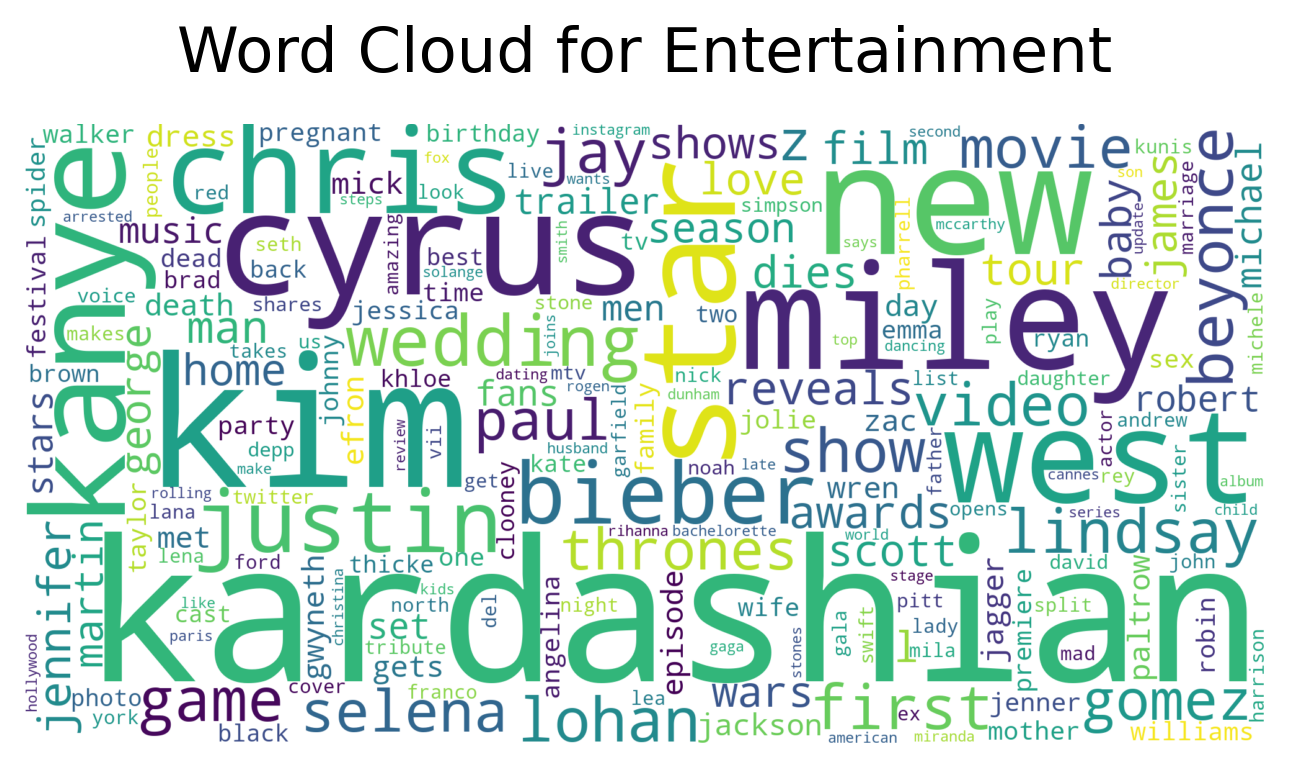

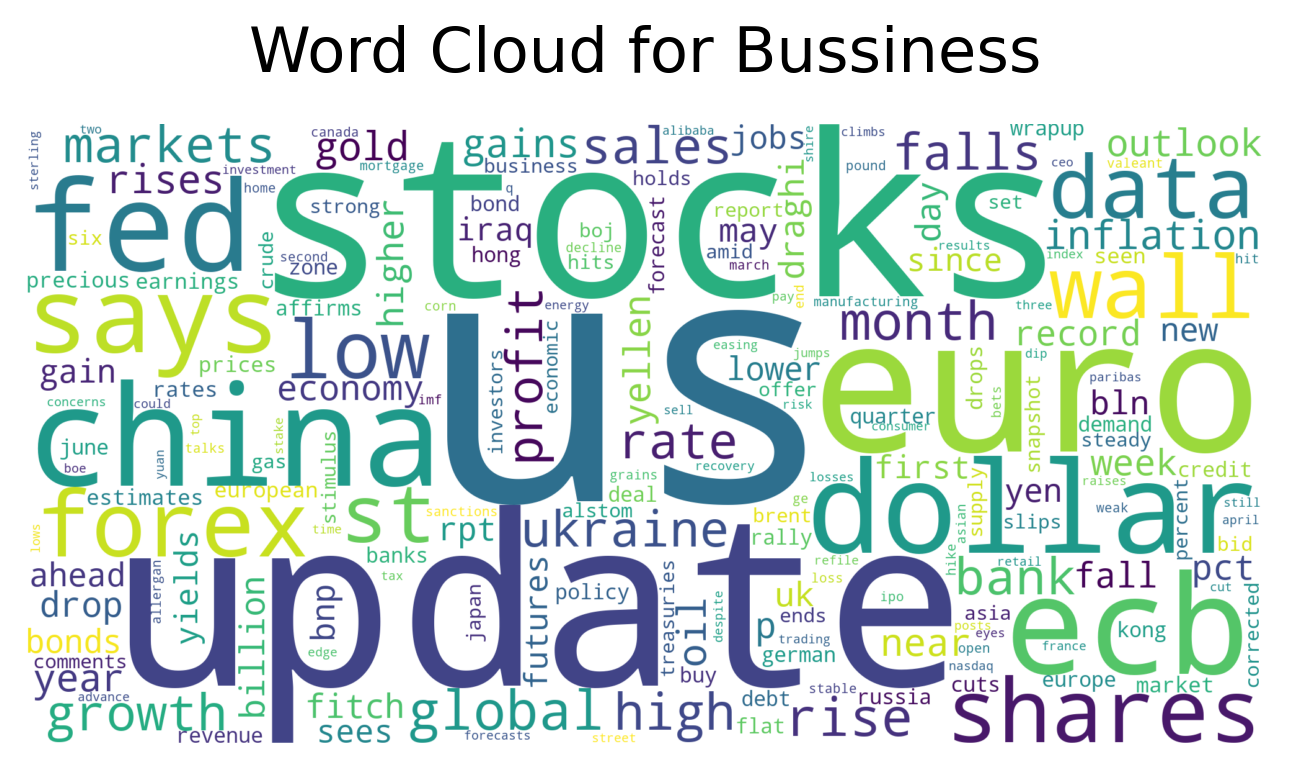

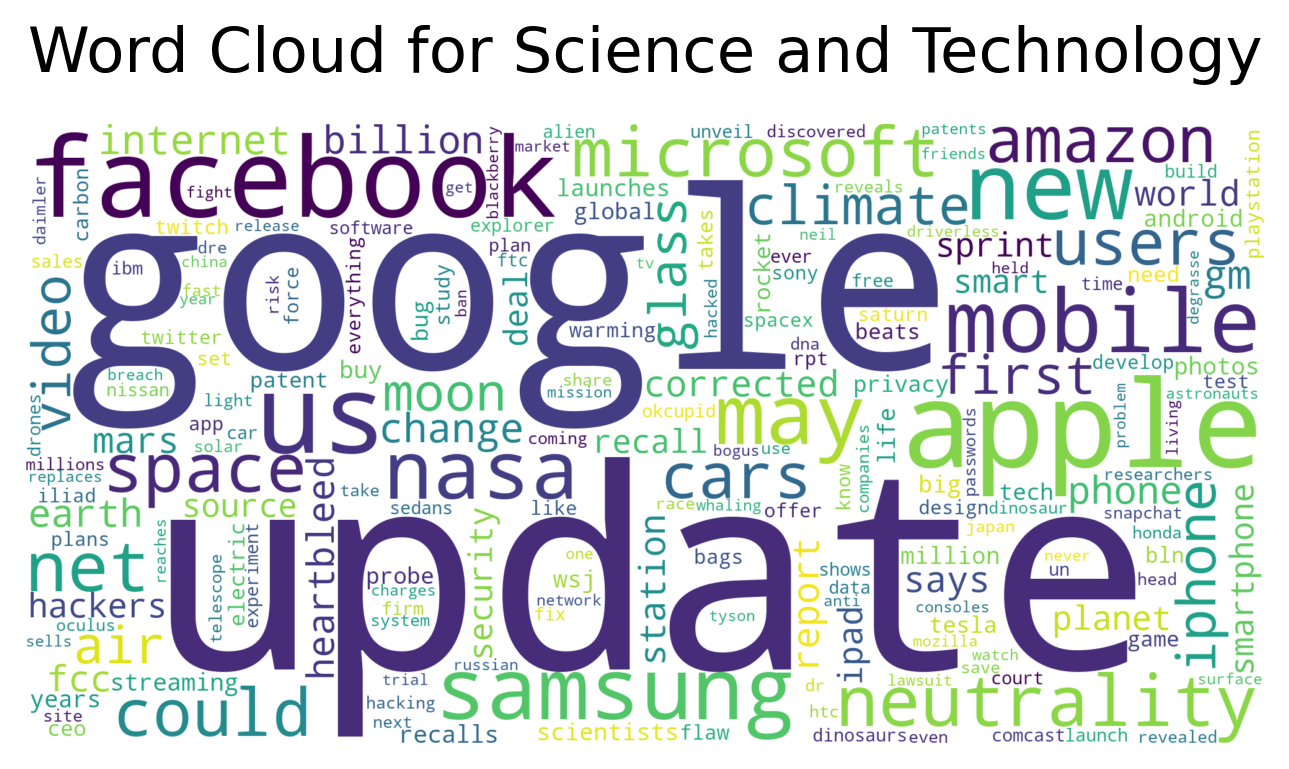

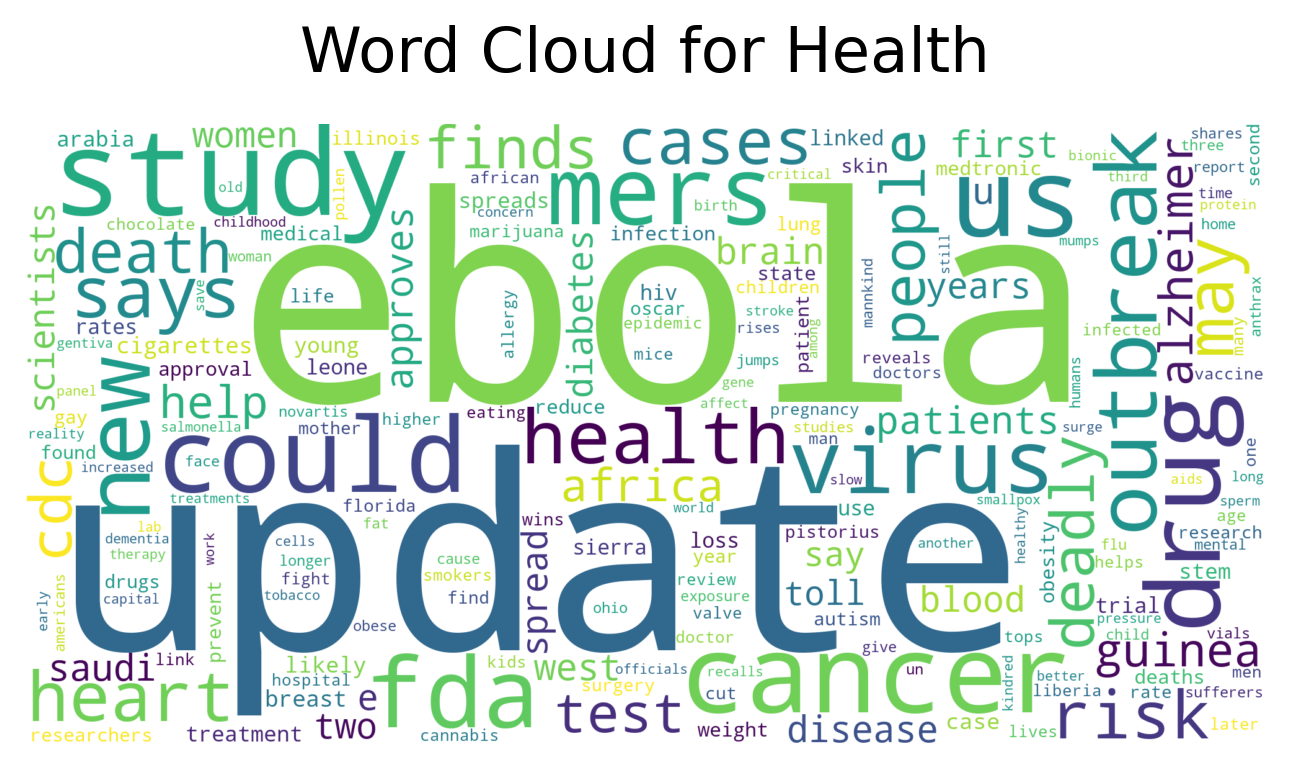

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic in ['Entertainment', 'Bussiness', 'Science and Technology', 'Health']:
    word_probabilities = llda_model.top_terms_of_topic(topic=topic, k=1000)

    # Calculate frequency of words based on probabilities
    word_freq = {word: prob for word, prob in word_probabilities}  

    # Generate word cloud
    wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(word_freq)

    title = f"Word Cloud for {topic}"
    
    plt.rcParams.update({'font.size': 15})
    
    # Display the generated word cloud
    plt.figure(dpi=250)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, pad=15.0)
    plt.savefig(f"word-clouds/{title}.png", bbox_inches='tight')
    plt.show()